/home/jupyter-228w1a4216/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter-228w1a4216/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/jupyter-228w1a4216/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


✅ Best model saved (epoch 1) | Val Acc: 0.4100
[Epoch 1] LR: 0.001000 | Train Loss: 1.8436 | Train Acc: 0.2895 | Val Loss: 1.5343 | Val Acc: 0.4100
✅ Best model saved (epoch 2) | Val Acc: 0.4267
[Epoch 2] LR: 0.001000 | Train Loss: 1.5484 | Train Acc: 0.3862 | Val Loss: 1.4428 | Val Acc: 0.4267
[Epoch 3] LR: 0.001000 | Train Loss: 1.4815 | Train Acc: 0.4183 | Val Loss: 1.4191 | Val Acc: 0.4256
[Epoch 4] LR: 0.001000 | Train Loss: 1.4556 | Train Acc: 0.4267 | Val Loss: 1.4645 | Val Acc: 0.4033
✅ Best model saved (epoch 5) | Val Acc: 0.4333
[Epoch 5] LR: 0.001000 | Train Loss: 1.4224 | Train Acc: 0.4324 | Val Loss: 1.3834 | Val Acc: 0.4333
>>> 🔓 Unfreezing feature extractor
✅ Best model saved (epoch 6) | Val Acc: 0.5300
[Epoch 6] LR: 0.001000 | Train Loss: 1.2883 | Train Acc: 0.4871 | Val Loss: 1.1811 | Val Acc: 0.5300
✅ Best model saved (epoch 7) | Val Acc: 0.5578
[Epoch 7] LR: 0.001000 | Train Loss: 1.1557 | Train Acc: 0.5393 | Val Loss: 1.0806 | Val Acc: 0.5578
✅ Best model saved (epo

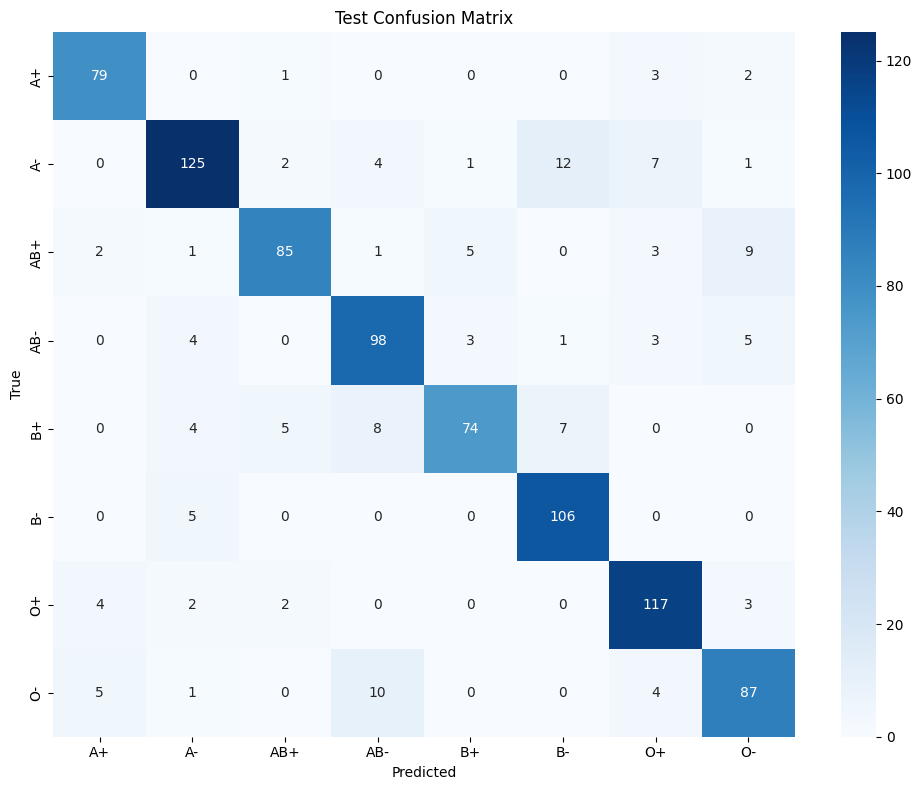

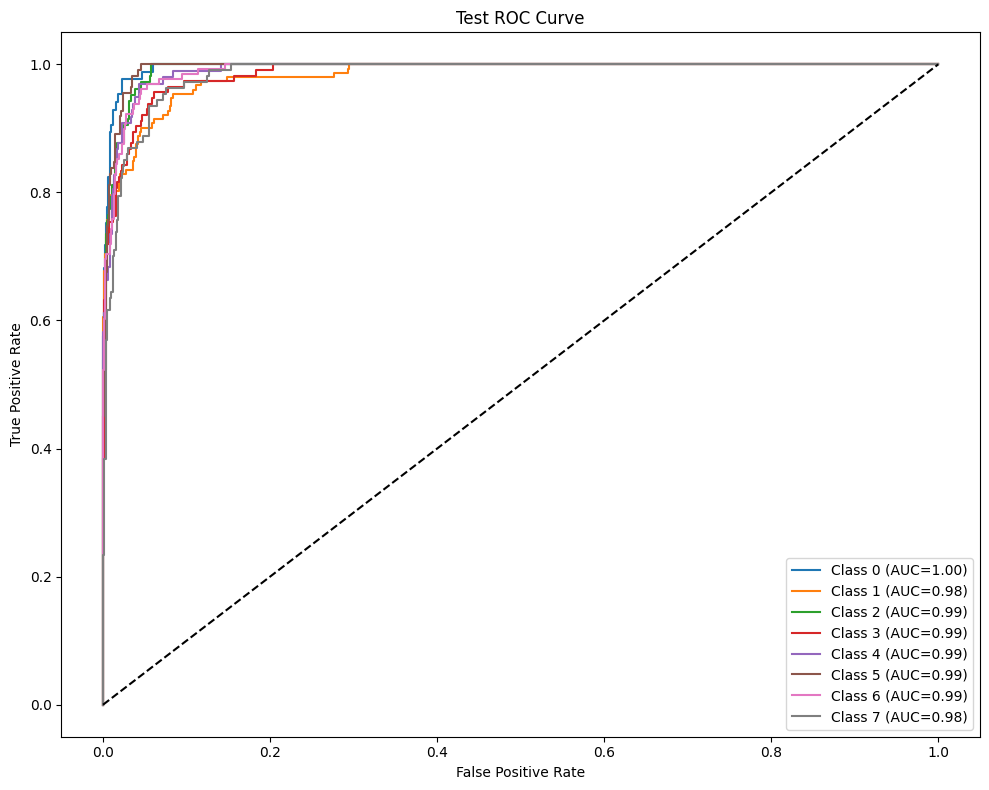

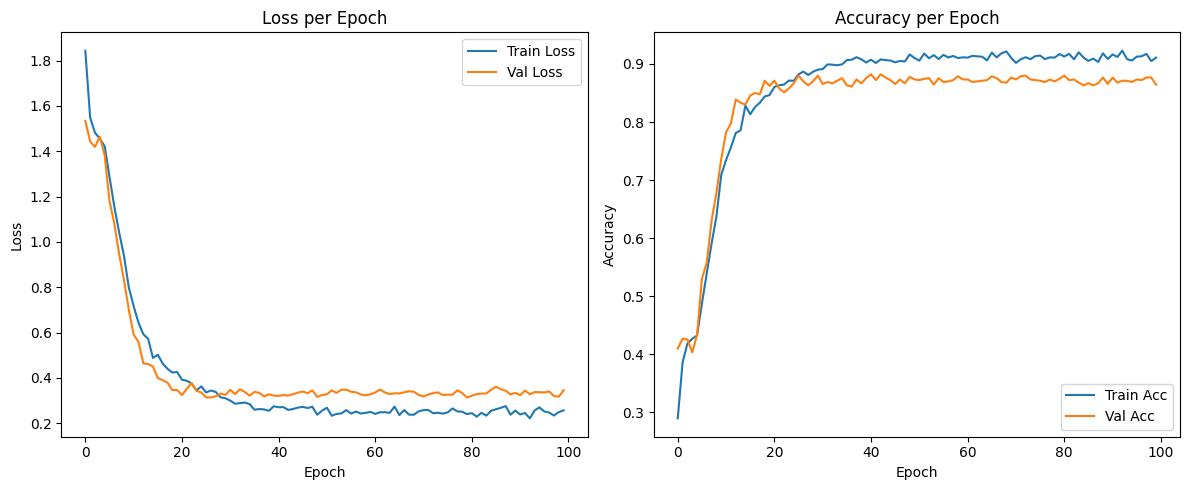

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from featureExtractor import Features

# --------------------- Configuration --------------------- #
BATCH_SIZE = 32
EPOCHS = 100
NUM_CLASSES = 8
LR_CLASSIFIER = 1e-3  # Higher LR for classifier
LR_FEATURE_EXTRACTOR = 1e-5  # Lower LR for feature extractor
IMAGE_SIZE = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------- Transforms with Data Augmentation --------------------- #
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val_test = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --------------------- Dataset & Stratified Split --------------------- #
dataset = datasets.ImageFolder(root="./dataset")  # Load without transform initially

labels = [label for _, label in dataset.samples]

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, temp_idx = next(splitter.split(np.zeros(len(labels)), labels))
temp_labels = [labels[i] for i in temp_idx]

splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(splitter2.split(np.zeros(len(temp_labels)), temp_labels))
val_idx = [temp_idx[i] for i in val_idx]
test_idx = [temp_idx[i] for i in test_idx]

# Custom dataset class to apply different transforms
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

train_ds = TransformedSubset(Subset(dataset, train_idx), transform=transform_train)
val_ds = TransformedSubset(Subset(dataset, val_idx), transform=transform_val_test)
test_ds = TransformedSubset(Subset(dataset, test_idx), transform=transform_val_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=os.cpu_count())
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=os.cpu_count())

# --------------------- Model Definition --------------------- #
class Classifier(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        features = Features(encoder_blocks=16)
        self.feature_extractor = nn.Sequential(*list(features.children())[:-2])  # Remove FC and avgpool
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.pool(x)
        return self.classifier(x)

model = Classifier(num_classes=NUM_CLASSES).to(DEVICE)

# Freeze feature extractor initially
for param in model.feature_extractor.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.classifier.parameters(), lr=LR_CLASSIFIER)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = [], []
best_val_acc = 0.0

# --------------------- Training --------------------- #
def train():
    global best_val_acc
    for epoch in range(EPOCHS):
        if epoch == 5:  # Unfreeze earlier to allow fine-tuning
            print(">>> 🔓 Unfreezing feature extractor")
            for param in model.feature_extractor.parameters():
                param.requires_grad = True
            optimizer.add_param_group({'params': model.feature_extractor.parameters(), 'lr': LR_FEATURE_EXTRACTOR})

        model.train()
        total_loss, correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            optimizer.step()

            total_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

        train_loss = total_loss / len(train_ds)
        train_acc = correct / len(train_ds)
        val_loss, val_acc = evaluate(val_loader, split="Validation", record=False)

        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        scheduler.step(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print(f"✅ Best model saved (epoch {epoch+1}) | Val Acc: {val_acc:.4f}")

        current_lr = optimizer.param_groups[0]['lr']  # Display LR of classifier
        print(f"[Epoch {epoch+1}] LR: {current_lr:.6f} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

# --------------------- Evaluation --------------------- #
def evaluate(loader, split="Test", record=True):
    model.eval()
    total_loss = 0
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)  # Use logits directly
            total_loss += loss.item() * images.size(0)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
            all_probs.append(probs.cpu())

    avg_loss = total_loss / len(loader.dataset)
    labels_np = torch.cat(all_labels).numpy()
    preds_np = torch.cat(all_preds).numpy()
    probs_np = torch.cat(all_probs).numpy()
    acc = np.mean(preds_np == labels_np)

    if record:
        print(f"\n[{split} Set]")
        print(f"Loss: {avg_loss:.4f} | Accuracy: {acc:.4f}")
        print(classification_report(labels_np, preds_np, digits=4))

        cm = confusion_matrix(labels_np, preds_np)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
        plt.title(f"{split} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

        labels_bin = label_binarize(labels_np, classes=list(range(NUM_CLASSES)))
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(NUM_CLASSES):
            fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_np[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(10, 8))
        for i in range(NUM_CLASSES):
            plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC={roc_auc[i]:.2f})")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f"{split} ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()

    return avg_loss, acc

# --------------------- Metrics Plot --------------------- #
def plot_metrics():
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Val Loss")
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label="Train Acc")
    plt.plot(val_acc_history, label="Val Acc")
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# --------------------- Main --------------------- #
if __name__ == "__main__":
    train()
    evaluate(test_loader, split="Test")
    plot_metrics()